In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt

from datetime import datetime
from sklearn import metrics
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.feature_selection import RFE
from sklearn.utils import shuffle
from IPython.display import display, Markdown, HTML

# Configurations
matplotlib.rcParams['agg.path.chunksize'] = 10000
%matplotlib inline

pd.set_option('display.float_format', lambda x: '%.3f' % x)
pd.set_option('display.max_rows', 15)
pd.set_option('display.max_columns', 10)

# On the Prediction of Apply Rate
For this experiment, a dataset from Glassdoor search within the date range 01/21/2018 and 01/26/2018 has been provided. The task is to predict that for a given search result, whether user will click the "Apply" button or not.

In [2]:
def shape_text(shape) :
    return str(shape[0]) + ' rows and ' + str(shape[1]) + ' columns'

# Read data
fname = 'ozan_p_pApply_intern_challenge_03_26_min.csv'
dtypes = {'search_date_pacific': np.datetime64}
dataset = pd.read_csv(fname, parse_dates=['search_date_pacific'], infer_datetime_format=True)

# Date for splitting
split_date = np.datetime64('2018-01-27')
train_set = dataset[dataset['search_date_pacific'] < split_date]
test_set = dataset[dataset['search_date_pacific'] == split_date]

output = 'Shape of the dataset is: \n' + \
    '- **Entire Dataset:** ' + shape_text(dataset.shape) + '\n' + \
    '- **Training Set:** ' + shape_text(train_set.shape) + '\n' + \
    '- **Test Set:** ' + shape_text(test_set.shape)
display(Markdown(output))

Shape of the dataset is: 
- **Entire Dataset:** 1200890 rows and 11 columns
- **Training Set:** 1084364 rows and 11 columns
- **Test Set:** 116526 rows and 11 columns

## Data Cleaning

Here, I am trying to identify missing values in the dataset. My observation indicates that "title_proximity_tfidf", "description_proximity_tfidf" and "city_match" has empty cells. However,  "mgoc_id" has some -1s, which I have assumed as missing values.

Basically, as "title_proximity_tfidf" and "description_proximity_tfidf" are related to "main_query_tfidf", so I would simply ignore those fields in my analysis, which will also save the effort of imputing those columns.

In [3]:
def fraction_missing(dataset):
    """ Identify the fraction of missing values in each column
        For "mgoc_id", -1s are assumed as missing values
    """
    cols = dataset.columns
    fractions = {}
    total = dataset.index.shape[0]
    
    for col in cols:
        if col == 'mgoc_id':
            # For mgoc_id, -1s are considered missing
            fractions[col] = dataset[dataset[col] == -1].shape[0] / total
        else:
            fractions[col] = dataset[dataset[col].isnull()].shape[0] / total
    
    return pd.DataFrame(list(fractions.items()), columns=['columns', 'fraction_of_null'])
    
fraction_missing(dataset)

,columns,fraction_of_null
0,title_proximity_tfidf,0.210
1,description_proximity_tfidf,0.210
2,main_query_tfidf,0.000
3,query_jl_score,0.000
4,query_title_score,0.000
5,city_match,0.214
6,job_age_days,0.000
7,apply,0.000
8,search_date_pacific,0.000
9,u_id,0.029


In [4]:
# Drop title_proximity_tfidf and description_proximity_tfidf from analysis
dataset = dataset.drop(['title_proximity_tfidf', 'description_proximity_tfidf'], axis=1)

## Dropping Duplicates

Initially I am dropping normal duplicates

In [5]:
prev_size = dataset.shape[0]

# Initially drop actual dupliates
dataset = dataset.drop_duplicates()

output = str(prev_size - dataset.shape[0]) + ' rows dropped'
display(Markdown(output))

output = 'After dropping the duplicates, the shape is: \n' + \
    '- **Entire Dataset:** ' + shape_text(dataset.shape)
display(Markdown(output))

58214 rows dropped

After dropping the duplicates, the shape is: 
- **Entire Dataset:** 1142676 rows and 9 columns

Apart from regular duplicates, we also have a situations when the value in "apply" field is different, while others are same. A user must have visited the job listing multiple times before clicking on the "Apply" button, which has resulted in this data. I will filter out those records and will keep only the ones with "apply" = 1.

In [6]:
prev_size = dataset.shape[0]

# Skip columns from the duplicacy check
columns = dataset.columns.difference(['apply', 'city_match', 'mgoc_id'])
dup_rows = dataset[dataset.duplicated(subset=columns, keep=False)]
# Determine indices to drop
indices_to_drop = dup_rows[dup_rows['apply'] == 0].index.values
# Drop duplicate with indices
dataset = dataset.drop(indices_to_drop, axis=0)

output = str(prev_size - dataset.shape[0]) + ' rows dropped'
display(Markdown(output))

output = 'After dropping the duplicates, the shape is: \n' + \
    '- **Entire Dataset:** ' + shape_text(dataset.shape)
display(Markdown(output))

141765 rows dropped

After dropping the duplicates, the shape is: 
- **Entire Dataset:** 1000911 rows and 9 columns

## Imputing Missing Values

Let's check the missing again

In [7]:
fraction_missing(dataset)

,columns,fraction_of_null
0,main_query_tfidf,0.000
1,query_jl_score,0.000
2,query_title_score,0.000
3,city_match,0.213
4,job_age_days,0.000
5,apply,0.000
6,search_date_pacific,0.000
7,u_id,0.029
8,mgoc_id,0.015


### Column "city_match"
I will impute the values in "city_match" by using Logistic Regression on "apply", "job_age_days" and "main_query_tfidf".

In [8]:
train_x = dataset.loc[dataset.city_match.notnull(), ['apply', 'job_age_days', 'main_query_tfidf']]
train_y = dataset.loc[dataset.city_match.notnull(), 'city_match']
predict_x = dataset.loc[dataset.city_match.isnull(), ['apply', 'job_age_days', 'main_query_tfidf']]
# Train Logistic Regression Model
model = LogisticRegression().fit(train_x, train_y)
# Predict and assign City Match
dataset.loc[dataset.city_match.isnull(), 'city_match'] = model.predict(predict_x)

### Column "u_id"
As there is no other information about u_id, I would assume NULL values in this column as a separate entity. This will not over-fit, as "u_id" will not be directly used in the analysis.

In [9]:
dataset.u_id = dataset.u_id.fillna('xxxxxxxx-xxxx-xxxx-xxxx-xxxxxxxxxxxx')

### Column "mgoc_id"
We can infer the value for this column using the information about the user. A particular user will only tend to select the jobs that belongs to a limited set of classes. Therefore, I have imputed each missing class with the mode of job classes used by the corresponding user.

In [10]:
# Generate counts of mgoc_id
count_mgoc_id = dataset.loc[dataset.mgoc_id != -1, ['u_id', 'mgoc_id']].groupby(['u_id', 'mgoc_id']).size()

for i, row in dataset[dataset.mgoc_id == -1].iterrows():
    try:
        # Select mode if user_id found
        mode_mgoc_id = count_mgoc_id.loc[(row['u_id'])].idxmax()
    except KeyError:
        # Select mode from xxxxx
        mode_mgoc_id = count_mgoc_id.loc[('xxxxxxxx-xxxx-xxxx-xxxx-xxxxxxxxxxxx')].idxmax()
        
    dataset.loc[i, 'mgoc_id'] = mode_mgoc_id

After performing the cleanup, our numbers are:

In [11]:
# Drop duplicates again
dataset = dataset.drop_duplicates()

# Split into Training and Testing set
train_set = dataset[dataset['search_date_pacific'] < split_date].reset_index(drop=True)
test_set = dataset[dataset['search_date_pacific'] == split_date].reset_index(drop=True)

# Normalize features in the training and test set
# Select first 5 columns for normalization, skipping city_match
selected_cols = train_set.columns[0:5].difference(['city_match'])
train_set[selected_cols] = train_set[selected_cols].apply(lambda col: (col - col.mean()) / col.std())
test_set[selected_cols] = test_set[selected_cols].apply(lambda col: (col - col.mean()) / col.std())

output = 'Shape of the new dataset is: \n' + \
    '- **Entire Dataset:** ' + shape_text(dataset.shape) + '\n' + \
    '- **Training Set:** ' + shape_text(train_set.shape) + '\n' + \
    '- **Test Set:** ' + shape_text(test_set.shape)
display(Markdown(output))

fraction_missing(dataset)

Shape of the new dataset is: 
- **Entire Dataset:** 1000907 rows and 9 columns
- **Training Set:** 904282 rows and 9 columns
- **Test Set:** 96625 rows and 9 columns

,columns,fraction_of_null
0,main_query_tfidf,0.000
1,query_jl_score,0.000
2,query_title_score,0.000
3,city_match,0.000
4,job_age_days,0.000
5,apply,0.000
6,search_date_pacific,0.000
7,u_id,0.000
8,mgoc_id,0.000


## Preliminary Analysis

### Apply Rate Distribution
Following plot shows distribution of apply rate across various job classes (mgoc_id). The mean of apply rate is around 7.5%.

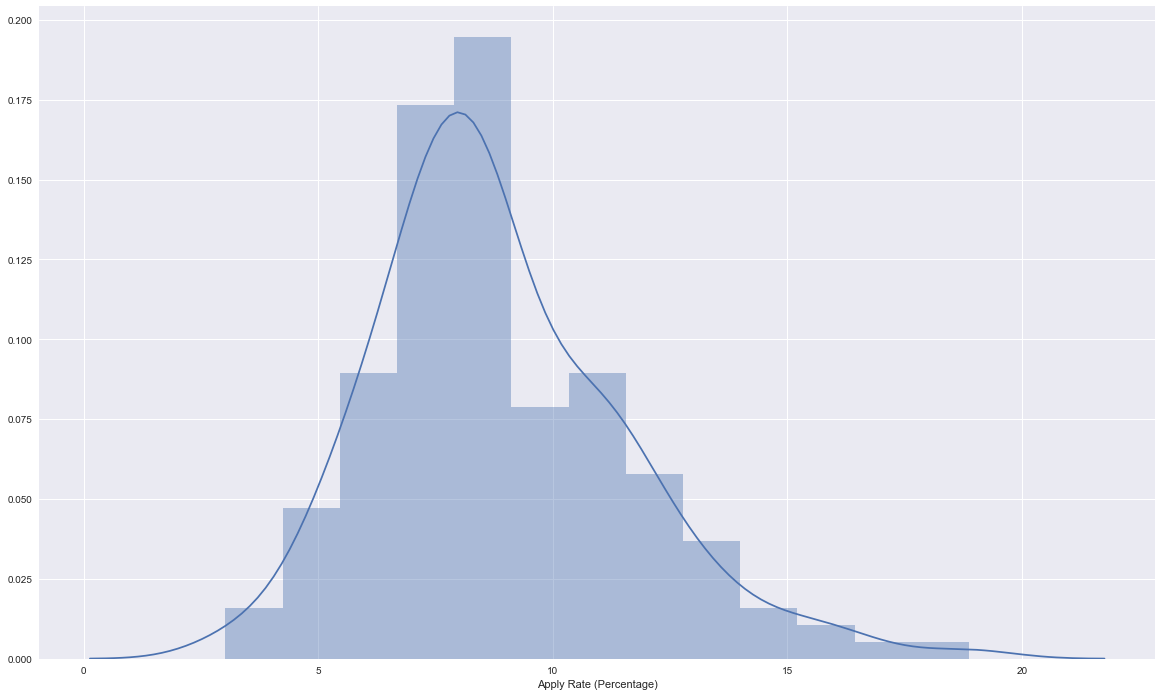

In [12]:
# Determine counts of apply per mgoc_id
apply_counts = dataset.groupby(['mgoc_id', 'apply']).size()
# Calculate Apply rate
apply_rate = apply_counts.groupby(level=0) \
    .apply(lambda count: count * 100 / count.sum()) \
    .reset_index(name='fraction')
papply_rate = apply_rate.loc[apply_rate['apply'] == 1, 'fraction']

# Plot Apply Rate
plt.figure(figsize=(20, 12))
sns.set(color_codes=True)
sns.distplot(papply_rate, axlabel='Apply Rate (Percentage)')
plt.show()

### Analysis of Features
The analysis from this section and on is performed on the training set only to avoid leaking of information about the test set.

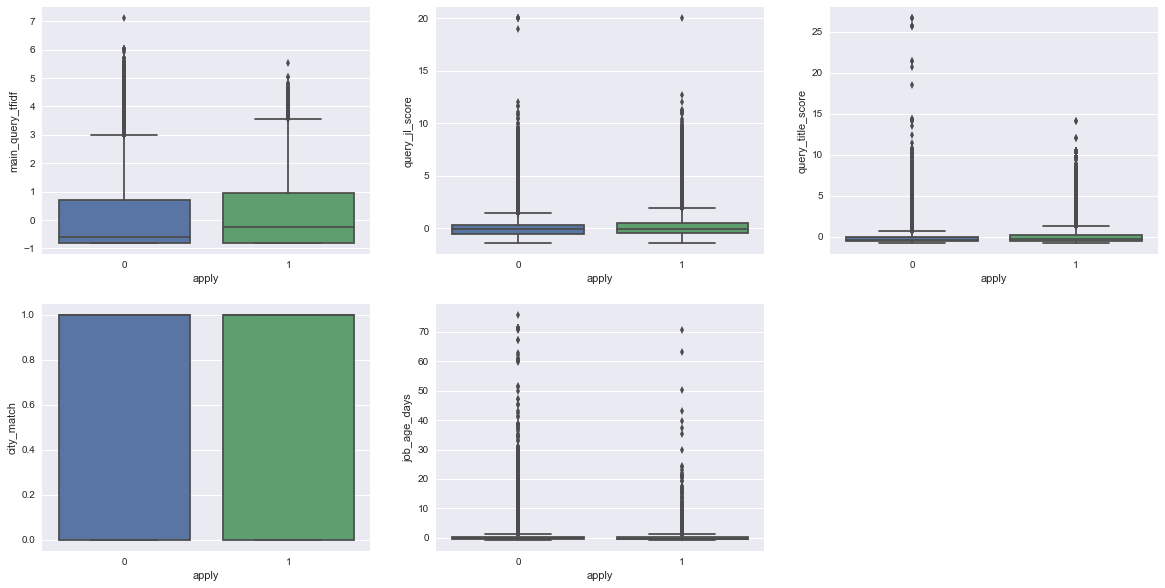

In [13]:
#train_set = train_set.drop_duplicates(train_set.columns[0:5])

# Select first 5 columns for analysis
selected_cols = train_set.columns[0:5]

# Generate box plots with respect to "apply"
fig = plt.figure(figsize=(20, 10))
for i, col in enumerate(selected_cols):
    fig.add_subplot(2, 3, i + 1)
    sns.boxplot(x='apply', y=col, data=train_set)

Let's hide the outliers get a better view of the data.

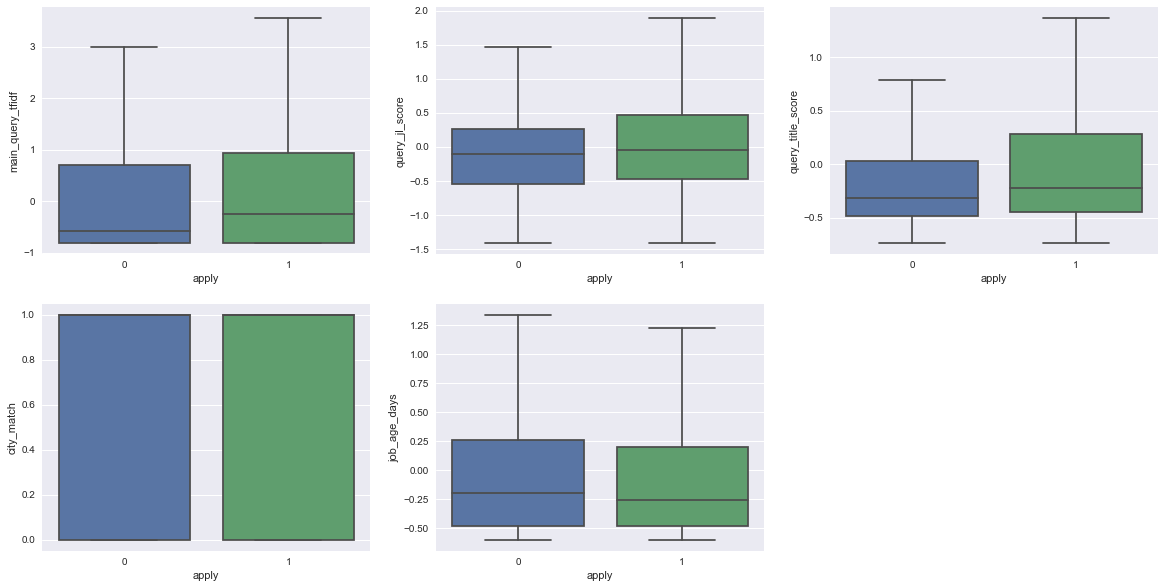

In [14]:
# Generate box plots with respect to "apply" without outliers
fig = plt.figure(figsize=(20, 10))
for i, col in enumerate(selected_cols):
    fig.add_subplot(2, 3, i + 1)
    sns.boxplot(x='apply', y=col, data=train_set, showfliers=False)

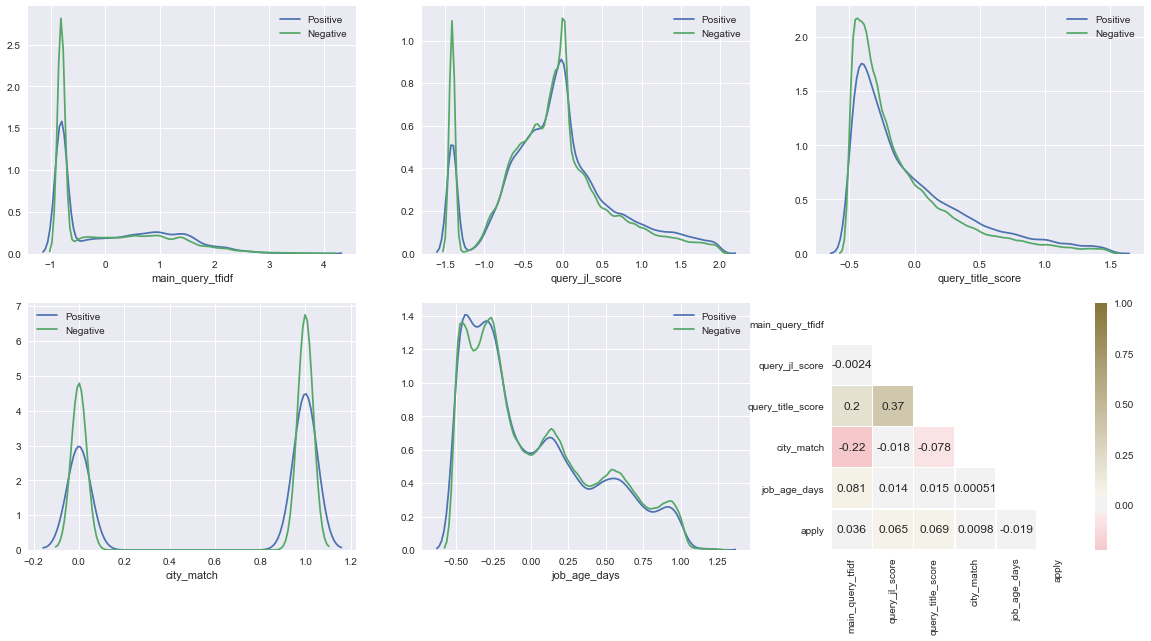

In [15]:
# Range of values to hide outliers from the distribution & scatter plot
col_range = {
    'main_query_tfidf': (-1, 4),
    'query_jl_score': (-1.5, 2.0),
    'query_title_score': (-0.5, 1.5),
    'city_match': (0, 1),
    'job_age_days': (-0.5, 1.25)
}

# Select first 5 columns
selected_cols = train_set.columns[0:5]

# Generate distribution plots
fig = plt.figure(figsize=(20, 10))
sns.set(color_codes=True)
for i, col in enumerate(selected_cols):
    fig.add_subplot(2, 3, i + 1)
    # Separate outliers from the training set
    data_sub = train_set[(train_set[col] >= col_range[col][0]) & (train_set[col] <= col_range[col][1])]
    sns.distplot(data_sub[data_sub['apply'] == 1][col], label='Positive', kde=True, hist=False)
    sns.distplot(data_sub[data_sub['apply'] == 0][col], label='Negative', kde=True, hist=False)
    
# Generate correlation matrix
selected_cols = train_set.columns[0:6]
corr = train_set[selected_cols].corr()

# Prepare mask and color palette
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True
cmap = sns.diverging_palette(10, 70, as_cmap=True)

# Plot heatmap of correation matrix
sns.set(style="white")
fig.add_subplot(2, 3, 6)
sns.heatmap(corr, mask=mask, square=True, cmap=cmap, center=0, annot=True, linewidths=.5)
plt.show()

The preliminary observation indicates that even after cleaning out duplicates, there is too much overlap in the data. The classification will be difficult with this dataset. Also, from the correlation matrix, we can observe that job_age_days is negatively correlated with the "apply", while others have positive correlation, which is normal.

### Degree of Overlap
Degree of overlap = Difference between the mean of features for both classes. It is as follows for each feature:

In [16]:
# Select first 5 columns 
selected_cols = train_set.columns[0:5]

# Computer the overlap degree
overlap_degree = dict()
for col in selected_cols:
    overlap_degree[col] = train_set.loc[train_set['apply'] == 0, col].mean() - \
    train_set.loc[train_set['apply'] == 1, col].mean()
    
pd.DataFrame(overlap_degree, index=['overlap degree']).abs()

,city_match,job_age_days,main_query_tfidf,query_jl_score,query_title_score
overlap degree,0.016,0.062,0.121,0.218,0.232


## Classification

In [17]:
# Split into training and test set
count_pos = train_set[train_set['apply'] == 1].shape[0]
count_neg = train_set[train_set['apply'] == 0].shape[0]
output = 'Positive Observations = **' + str(count_pos) + '** and Negative Observations = **' + str(count_neg) + '**'
display(Markdown(output))

Positive Observations = **90217** and Negative Observations = **814065**

The ratio of Positive to Negative observations is 1:9, which indicates unbalanced data. Therefore, under-sampling must be done on the positive class.

In [16]:
def balance_data(dataset):
    """ Balance the provided dataset by under-sampling
    """
    pos_data = dataset[dataset['apply'] == 1]
    neg_data = dataset[dataset['apply'] == 0]
    
    sample_size = min(pos_data.shape[0], neg_data.shape[0])
    pos_sample = pos_data.sample(n=sample_size)
    neg_sample = neg_data.sample(n=sample_size)
    
    return shuffle(pd.concat([pos_sample, neg_sample]))

# Balance the training set
train_set_bal = balance_data(train_set)

# Remove attributes not required by the model
unnecessary_cols = ['apply', 'u_id', 'search_date_pacific', 'mgoc_id']
train_x = train_set_bal.drop(unnecessary_cols, axis=1)
train_y = train_set_bal['apply']

test_x = test_set.drop(unnecessary_cols, axis=1)
test_y = test_set['apply']

In [17]:
def analyze_model(model, test_x, test_y) :
    """ Generates analysis of the model. It includes
        * Probability Distribution
        * ROC Curve
        * Confusion Matrix
        * Accuracy / Precision / Recall / F-Score / AUC
    """
    
    # Prediction probabilities
    predict_prob = model.predict_proba(test_x)[:, 0]
    fpr, tpr, thresh = metrics.roc_curve(test_y, predict_prob, pos_label=1)
    
    # Predict classes
    predict = model.predict(test_x)
    
    # Generate Confusion Matrix
    cm = metrics.confusion_matrix(test_y, predict)
    cm = np.flip(np.flip(cm, axis=0), axis=1)
    cm = pd.DataFrame(cm, index=['positive', 'negative'], columns=['positive', 'negative'])
    
    # Prepare statistics Dataframe
    stats = dict()
    stats['accuracy'] = metrics.accuracy_score(test_y, predict)
    stats['precision'], stats['recall'], stats['f-score'], stats['support'] = \
        metrics.precision_recall_fscore_support(test_y, predict)
    stats['auc'] = np.trapz(tpr, fpr)
    stats = pd.DataFrame(stats, index=['negative', 'positive']).round(2)
    
    # Generate Plots
    fig = plt.figure(figsize=(20, 5))
    
    # Plot Confusion matrix heatmap
    sns.set(style="white")
    fig.add_subplot(1, 3, 1)
    cmap = sns.diverging_palette(255, 255, as_cmap=True)
    sns.heatmap(cm, fmt="d", cmap=cmap, annot=True, square=True, cbar=False, linewidths=.5)
    plt.title('Confusion Matrix')
    plt.ylabel('Actual');
    plt.xlabel('Predicted');

    # Plot probability distribution
    sns.set(color_codes=True)
    fig.add_subplot(1, 3, 2)
    pos_prob = predict_prob[test_y.index[test_y == 1]]
    neg_prob = predict_prob[test_y.index[test_y == 0]]
    sns.distplot(pos_prob, label='Positive Class', hist=False)
    sns.distplot(neg_prob, label='Negative Class', hist=False)
    plt.title('Probability Distribution')
    
    # ROC Curve
    fig.add_subplot(1, 3, 3)
    plt.plot([0,1],[0,1],'r--')
    plt.plot(fpr, tpr)
    plt.title('ROC Curve')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    
    plt.show()
    
    return stats

### Classification using Logistic Regression
Initially, Logistic Regression is tried to check whether the classes can be linearly separated. Clearly, it is not possible.

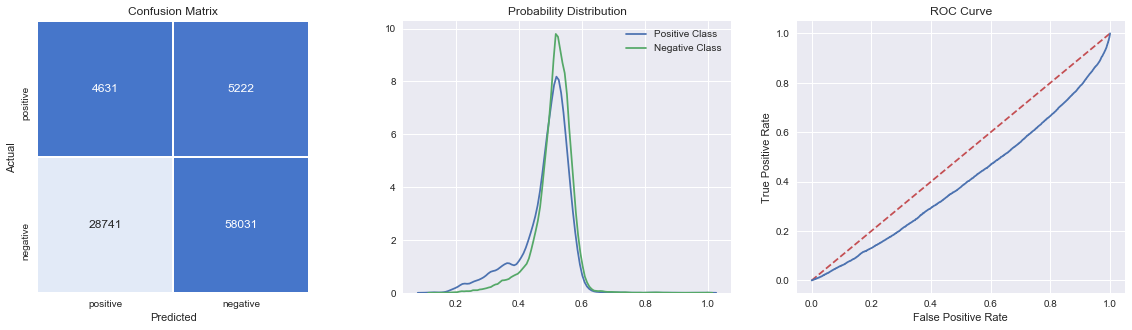

,accuracy,auc,f-score,precision,recall,support
negative,0.650,0.400,0.770,0.920,0.670,86772
positive,0.650,0.400,0.210,0.140,0.470,9853


In [19]:
# Create and fit Logistic Regression Classifier
model = LogisticRegression().fit(train_x, train_y)
analyze_model(model, test_x, test_y)

### Classification using Decision Tree
Even with the Decision tree, the AUC is just 0.48, which is still not up to the mark.

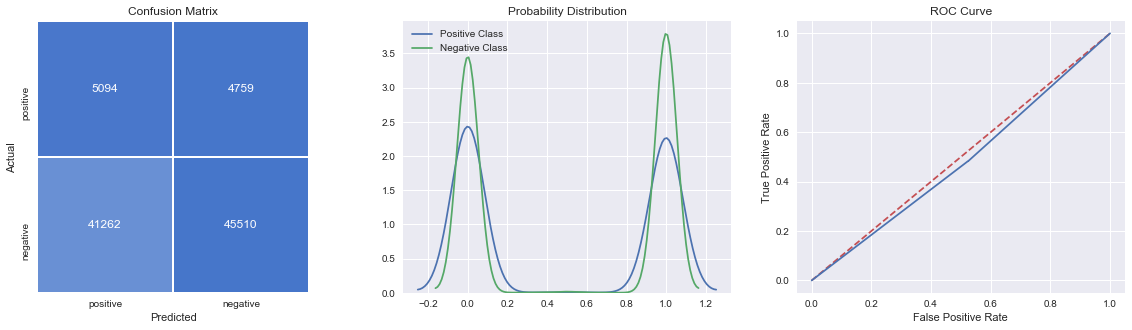

,accuracy,auc,f-score,precision,recall,support
negative,0.520,0.480,0.660,0.910,0.520,86772
positive,0.520,0.480,0.180,0.110,0.520,9853


In [20]:
# Create and fit Decision Tree Classifier
model = DecisionTreeClassifier(max_features=3, presort=True).fit(train_x, train_y)
analyze_model(model, test_x, test_y)

## Segmentation of Data
In an attempt to improve the classification, let's try to segment records on the basis of Job Class. We will use K-Means clustering with 3 clusters and Decision Tree Model will be trained individually on those clusters.

In [ ]:
from sklearn.cluster import KMeans
# Create Clusters of data using K-Means Clustering (3 Clusters)
n_clusters = 3
kmc = KMeans(n_clusters=n_clusters).fit(train_set[['mgoc_id']])
test_labels = kmc.predict(test_set[['mgoc_id']])

In [ ]:
unnecessary_cols = ['apply', 'u_id', 'search_date_pacific', 'mgoc_id']
# Create Decision Tree Classifier Instance
model = DecisionTreeClassifier()

for i in range(n_clusters):    
    train_indexes = np.where(kmc.labels_ == i)[0]
    test_indexes = np.where(test_labels == i)[0]
    
    # Balance the training data
    train_set_bal = balance_data(train_set.iloc[train_indexes])
    
    # Remove attributes not required by the model
    train_x = train_set_bal.drop(unnecessary_cols, axis=1).reset_index(drop=True)
    train_y = train_set_bal.loc[:, 'apply'].reset_index(drop=True)

    test_x = test_set.iloc[test_indexes].drop(unnecessary_cols, axis=1).reset_index(drop=True)
    test_y = test_set.loc[test_indexes, 'apply'].reset_index(drop=True)
    
    model.fit(train_x, train_y)
    
    display(Markdown('##### Cluster ' + str(i + 1)))
    stats = analyze_model(model, test_x, test_y)
    display(HTML(stats.to_html()))

## Conclusions
As it can be observed from the preliminary visualizations, the given features do not separate classes properly. More features must be included to get a clearer separation. 